In [1]:
import pandas as pd

In [2]:
# Load the dataset
dataset = pd.read_csv(
    r'C:\Users\Asus\OneDrive\Desktop\Energy Forecasting ML Model\household_power_consumption.txt',
    sep=';',
    header=0,
    low_memory=False,
)

# Combine 'Date' and 'Time' columns into a single 'datetime' column
dataset['datetime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], dayfirst=True)

# Set 'datetime' as the index
dataset.set_index('datetime', inplace=True)

# Drop 'Date' and 'Time' columns as they are no longer needed
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

# View the first few rows to check
print(dataset.head())


                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          

In [3]:
import numpy as np

# Replace '?' with NaN
dataset.replace('?', np.nan, inplace=True)


In [4]:
# Fill missing values with the value from the same time one day ago
def fill_missing(values):
    one_day = 60 * 24  # 1440
    for row in range(one_day, values.shape[0]):  # Start from the row after one day
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]


In [5]:
# Fill missing values in the dataset
import numpy as np

# Ensure all columns are numeric (convert any non-numeric columns to NaN)
dataset = dataset.apply(pd.to_numeric, errors='coerce')

# Fill missing values using the fill_missing function
fill_missing(dataset.values)


In [6]:
print(np.isnan(dataset.values).sum())  # Should return 0 if all missing values are filled


0


In [7]:
print(dataset.head())  # Display the first few rows to confirm changes


                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [8]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [9]:
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [10]:
from pandas import read_csv

# Load the dataset without 'infer_datetime_format'
dataset = read_csv('household_power_consumption.csv', header=0, parse_dates=['datetime'], index_col=['datetime'])

# Resample the data to daily totals
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

# Summarize the data
print(daily_data.shape)
print(daily_data.head())

# Save the resampled data
daily_data.to_csv('household_power_consumption_days.csv')


(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [11]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [12]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [13]:
from numpy import split
from numpy import array
from pandas import read_csv

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])

# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])


(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.454 2197.006


In [14]:
# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [15]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [16]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

In [17]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, parse_dates=['datetime'], index_col=['datetime'])


In [18]:
# split into train and test
train, test = split_dataset(dataset.values)

In [19]:
# convert training data into a series
series = to_series(train)

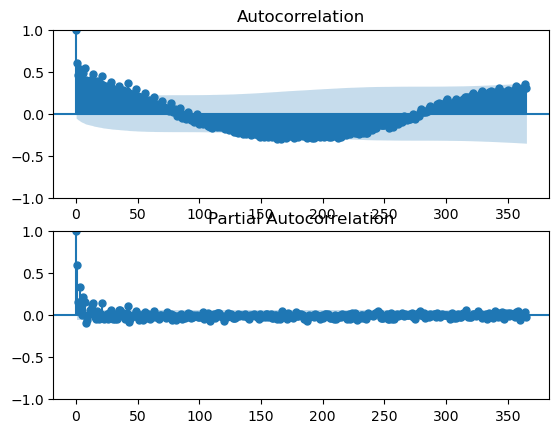

In [20]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plots
plt.figure()
lags = 365
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
plt.show()


In [21]:
lags = 50

In [22]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
        
    predictions = np.array(predictions)
    # convert history into a univariate series
    series = to_series(history)
    
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


In [61]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
dataset = pd.read_csv('household_power_consumption_days.csv', 
                      header=0, 
                      parse_dates=['datetime'], 
                      index_col='datetime')

# Ensure the index is sorted by datetime
dataset = dataset.sort_index()

# Set the frequency of the datetime index (assuming daily frequency)
dataset = dataset.asfreq('D')

# Extract the series (assuming you want to use the 'Global_active_power' column)
series = dataset['Global_active_power']

# Define the model
model = ARIMA(series, order=(7, 0, 0))

# Fit the model
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

# save model
model_fit.save('model.pkl')

#import joblib

# Serialize and save the model
#joblib.dump(model, 'EnergyForecast_1.sav')

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1442
Model:                  ARIMA(7, 0, 0)   Log Likelihood              -10771.192
Date:                 Sun, 12 Jan 2025   AIC                          21560.384
Time:                         19:02:05   BIC                          21607.848
Sample:                     12-16-2006   HQIC                         21578.101
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1567.8391     96.513     16.245      0.000    1378.678    1757.000
ar.L1          0.3617      0.020     18.091      0.000       0.323       0.401
ar.L2         -0.0144      0.022     -0.648 

In [63]:
# make forecast
yhat = model_fit.predict(len(series), len(series)+6)

In [65]:
# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

arima: [381.301] 393.6, 398.3, 356.2, 377.0, 392.9, 304.8, 433.4


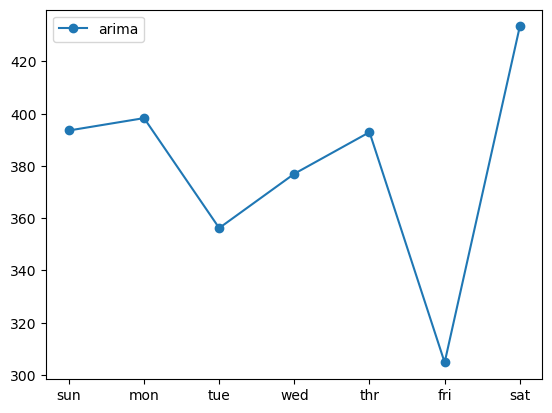

In [68]:
# arima forecast
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit()
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

# load the new file
# load the new file without the deprecated argument
dataset = read_csv('household_power_consumption_days.csv', header=0, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()